# Getting Started with Spanky's

In [289]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import simpy
import itertools
import random
import pandas as pd
import numpy as np

Number of Orders Received =  18
Number of Orders Finished =  18
Number of Late Orders =  8
Average lateness for late orders =  5.067238559033232
Maximum lateness of late orders =  8.18603305673


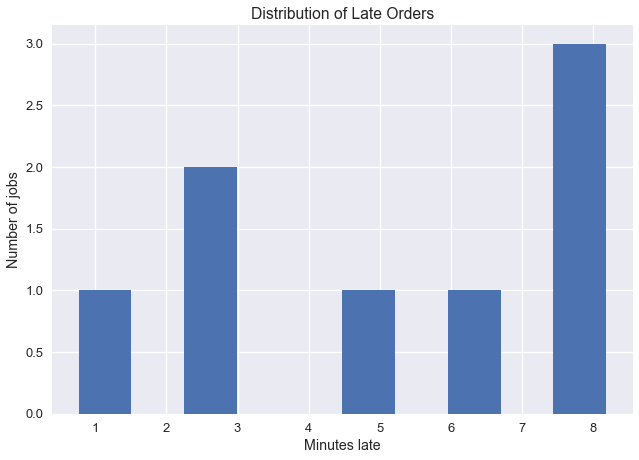

In [290]:
T_ORDER = 10              # average time between orders (Poisson)
T_SIM = 180               # simulation period
N_OVENS = 2
N_SERVERS = 1

menu = {
    'pizza': {'prob': 0.4, 'prep': 0, 'cook': 13},
    'sticks': {'prob': 0.3, 'prep': 1, 'cook': 10},
    'nuggets': {'prob': 0.2, 'prep': 1, 'cook': 10},
    'rolls': {'prob': 0.1, 'prep': 0, 'cook': 8}
}

items = [k for k in menu.keys()]
probs = [menu[k]['prob'] for k in menu.keys()]

class Spanky(object):

    def __init__(self):
        self.env = simpy.Environment()
        self._data = dict()
        self.server = simpy.Resource(self.env,N_SERVERS)
        self.oven = simpy.Resource(self.env,N_OVENS)
        self.orders_in_process = 0
        self.orderQueue = pd.Series([0],[0])
        self.env.process(self.orderGenerator())
        
    def writeLog(self,orderId,item,event,t=None):
        if t==None:
            t = self.env.now
        self._data[orderId,item,event] = t

    def writeOrderQueue(self,inc):
        self.orderQueue[self.env.now-0.00001] = self.orders_in_process
        self.orders_in_process += inc
        self.orderQueue[self.env.now] = self.orders_in_process
        
    @property
    def log(self):
        df = pd.DataFrame([[a,b,c,self._data[a,b,c]] for (a,b,c) in self._data.keys()])
        df.columns = ['OrderID','Item','Event','Time']
        return df
        
    def order(self,orderId,item):
        # request server
        with self.server.request() as serverreq:
            # wait for server
            yield serverreq
            # write on log
            self.writeLog(orderId,item,'1 order')
            self.writeOrderQueue(+1)
            # time to take order
            yield self.env.timeout(0.5)
            # issue receipt
            self.writeLog(orderId,item,'2 receipt')
            # tell customer when order should be done
            tquote = self.env.now + menu[item]['prep'] + menu[item]['cook']
            self.writeLog(orderId,item,'6 tquote',tquote)
            
        # request server
        with self.server.request() as serverreq:
            # wait for server
            yield serverreq
            # write onto order log
            self.writeLog(orderId,item,'3 prep')
            # wait until prep is finished
            yield self.env.timeout(menu[item]['prep'])
        
        # request oven
        with self.oven.request() as ovenreq:
            # wait until oven is available
            yield ovenreq
            # request server to load the oven
            with self.server.request() as serverreq:
                # wait for server
                yield serverreq
                # write on log
                self.writeLog(orderId,item,'4 oven') 
            # wait to finish cooking
            yield self.env.timeout(menu[item]['cook'])
            # request server to remove item from oven
            with self.server.request() as serverreq:
                # wait for server
                yield serverreq
                self.writeLog(orderId,item,'5 finish')
        self.writeLog(orderId,item,'7 late',max(0,self.env.now - tquote))
        self.writeOrderQueue(-1)
            
    def orderGenerator(self):
        for orderId in itertools.count():
            yield self.env.timeout(random.expovariate(1.0/T_ORDER))
            item = np.random.choice(items,p = probs)
            self.writeLog(orderId,item,'0 arrival')
            self.env.process(self.order(orderId,item))

    def run(self,t_sim = T_SIM):
        self.env.run(until=t_sim)
        
# create an order fulfillment instance
w = Spanky()

# run a simulation for a specified period
w.run()

# see data trace
w.log.pivot_table(values='Time',index=['OrderID','Item'],columns=['Event'])

# summarize data
data = w.log.pivot_table(values='Time',index=['OrderID','Item'],columns=['Event'])

print("Number of Orders Received = ", data[data['1 order']>0]['1 order'].count())
print("Number of Orders Finished = ", data[data['5 finish']>0]['5 finish'].count())
print("Number of Late Orders = ", data[data['7 late']>0]['7 late'].count())
print("Average lateness for late orders = ", data[data['7 late']>0]['7 late'].mean())
print("Maximum lateness of late orders = ", data[data['7 late']>0]['7 late'].max())

late = data[data['7 late']>0]
late

late['7 late'].hist()
plt.title('Distribution of Late Orders')
plt.ylabel('Number of jobs')
plt.xlabel('Minutes late')

In [291]:
data

,Event,0 arrival,1 order,2 receipt,3 prep,4 oven,5 finish,6 tquote,7 late
OrderID,Item,,,,,,,,
0,pizza,2.075477,2.075477,2.575477,2.575477,2.575477,15.575477,15.575477,0.000000
1,nuggets,4.430454,4.430454,4.930454,4.930454,5.930454,15.930454,15.930454,0.000000
2,nuggets,16.009172,16.009172,16.509172,16.509172,17.509172,27.509172,27.509172,0.000000
3,sticks,32.779337,32.779337,33.279337,33.279337,34.279337,44.279337,44.279337,0.000000
4,rolls,47.676914,47.676914,48.176914,48.176914,48.176914,56.176914,56.176914,0.000000
5,sticks,64.063624,64.063624,64.563624,64.563624,65.563624,75.563624,75.563624,0.000000
6,rolls,88.912423,88.912423,89.412423,89.412423,89.412423,97.412423,97.412423,0.000000
7,pizza,110.101372,110.101372,110.601372,110.601372,110.601372,123.601372,123.601372,0.000000
8,sticks,111.865898,111.865898,112.365898,112.365898,113.365898,123.365898,123.365898,0.000000


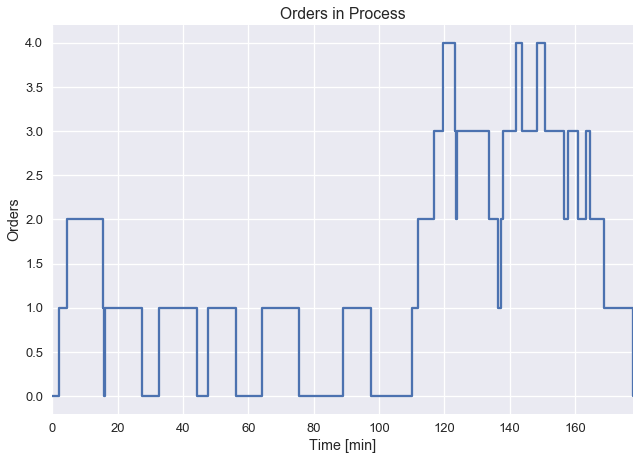

In [292]:
w.orderQueue.plot()
plt.xlabel('Time [min]')
plt.ylabel('Orders')
plt.title('Orders in Process')